In [261]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
volleyball_set=pd.read_csv("Downloads\dataset_full.csv")
data=pd.DataFrame(volleyball_set)
data.info()
# 1. How does a team's serve efficiency change over the course of a match?
# 2.Can we use ARIMA analysis to predict a team's percentage in future cases?
# 3. How does Serve efficiency change depending on the type of serve?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rally               2429 non-null   int64  
 1   round               2428 non-null   float64
 2   team                2428 non-null   object 
 3   receive_location    2148 non-null   float64
 4   digger_location     2143 non-null   float64
 5   pass_land_location  2013 non-null   float64
 6   hitter_location     1915 non-null   float64
 7   hit_land_location   2042 non-null   float64
 8   pass_rating         2062 non-null   object 
 9   set_type            1938 non-null   object 
 10  set_location        1934 non-null   object 
 11  hit_type            2058 non-null   object 
 12  num_blockers        2054 non-null   float64
 13  block_touch         2054 non-null   object 
 14  serve_type          1498 non-null   object 
 15  win_reason          1498 non-null   object 
 16  lose_r

In [262]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [263]:
serve=pd.Series(data["serve_type"])
serve.isnull()
serve.fillna("continue",inplace=True)

In [264]:
win=pd.Series(data["win_reason"])
win.isnull()
win.fillna("ongoing",inplace=True)

In [265]:

lose=pd.Series(data["lose_reason"])
lose.isnull()
lose.fillna("ongoing",inplace=True)

In [266]:
data.rename(columns={"pass_rating":"in_out_sys"},inplace=True)
data.insert(8,"pass_rate(0-3)",0)

In [267]:
# gives quantative passing info so we can analyze quality of pass 
data["pass_rate(0-3)"]=data["pass_rate(0-3)"].mask(data["win_reason"] =="ace",0)
data["pass_rate(0-3)"]=data["pass_rate(0-3)"].mask(data["pass_land_location"]==13,3)
data["pass_rate(0-3)"]=data["pass_rate(0-3)"].mask(data["pass_land_location"]>15,1)
data["pass_rate(0-3)"]=data["pass_rate(0-3)"].mask((data["pass_land_location"]>=11) & (data["pass_land_location"]<13),2)
data["pass_rate(0-3)"]=data["pass_rate(0-3)"].mask((data["pass_land_location"]>=7) & (data["pass_land_location"]<10),2)
data["pass_rate(0-3)"]=data["pass_rate(0-3)"].mask((data["pass_land_location"]>=1) & (data["pass_land_location"]<7),1)
# fills null values with -1 
data.fillna(-1,inplace=True)

In [268]:
# quantifying block touch data with a 1 or 0 
data['block_touch']=data['block_touch'].mask(data['block_touch']=='yes',1)
data['block_touch']=data['block_touch'].mask(data['block_touch']=='no',0)

In [269]:
# inserting match column so we can indentify trends throughout a match (passing, hitting % etc. ) 
data.insert(0,"match",1)

In [270]:
# divides up our dataset match by match 
filter=data['rally']==1
data.loc[:346,'match'] = 1
data.loc[347:580, 'match'] = 2
data.loc[581:850, 'match'] = 3
data.loc[850:1061, 'match'] = 4
data.loc[1062:1364, 'match'] = 5
data.loc[1364:1586, 'match'] = 6
data.loc[1586:1804, 'match'] = 7
data.loc[1805:2085, 'match'] = 8
data.loc[2085:, 'match'] = 9

In [347]:
# creates new data-frame serve_data 
filter = data['round']==1
serve_data=pd.DataFrame(data[filter])

# fixes some indiscrepancies within our pass rating 
serve_data['pass_rate(0-3)']=serve_data['pass_rate(0-3)'].mask(serve_data['win_reason']=='ace',0)
serve_data['pass_rate(0-3)']=serve_data['pass_rate(0-3)'].mask(serve_data['win_reason']=='serve_error',-1)

# creates our serve rating column and applies the proper values for each pass/serve type
serve_data['srv_rating']=0
serve_data['srv_rating']=serve_data['srv_rating'].mask(serve_data['win_reason']=='ace',4)
serve_data['srv_rating']=serve_data['srv_rating'].mask(serve_data['win_reason']=='serve_error',0)
serve_data['srv_rating']=serve_data['srv_rating'].mask(serve_data['pass_rate(0-3)']==3,1)
serve_data['srv_rating']=serve_data['srv_rating'].mask(serve_data['pass_rate(0-3)']==2,2)
serve_data['srv_rating']=serve_data['srv_rating'].mask(serve_data['pass_rate(0-3)']==1,3)
serve_data['srv_rating']=serve_data['srv_rating'].mask((serve_data['pass_rate(0-3)']==0) & (serve_data['win_reason']!='ace'),3)
serve_data


,match,rally,round,team,receive_location,digger_location,pass_land_location,hitter_location,hit_land_location,pass_rate(0-3),...,set_type,set_location,hit_type,num_blockers,block_touch,serve_type,win_reason,lose_reason,winning_team,srv_rating
0,1,1,1.0,b,4.0,4.0,13.0,13.0,7.0,3,...,in,quick,off_speed,2.0,0,jump,ongoing,ongoing,a,1
8,1,2,1.0,b,3.0,3.0,13.0,14.0,2.0,3,...,in,quick,off_speed,2.0,0,jump,kill,kill,b,1
9,1,3,1.0,a,2.0,2.0,12.0,11.0,11.0,2,...,in,oppo,hit,2.0,1,jump,ongoing,ongoing,a,2
11,1,4,1.0,b,-1.0,-1.0,-1.0,-1.0,-1.0,-1,...,-1,-1,-1,-1.0,-1,jump,serve_error,serve_error,b,0
12,1,5,1.0,a,7.0,8.0,13.0,14.0,6.0,3,...,in,quick,hit,2.0,0,float,kill,kill,a,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2422,9,209,1.0,b,3.0,3.0,26.0,6.0,1.0,1,...,out,d-ball,hit,3.0,0,jump,kill,kill,b,3
2423,9,210,1.0,a,3.0,3.0,8.0,15.0,18.0,2,...,out,outside,hit,2.0,1,jump,tool,tool,a,2
2424,9,211,1.0,b,7.0,2.0,8.0,15.0,3.0,2,...,out,outside,hit,2.0,1,jump,ongoing,ongoing,a,2
2426,9,212,1.0,b,7.0,7.0,13.0,15.0,17.0,3,...,in,outside,tip,2.0,0,jump,hit_error,hit_error,a,1


In [272]:
# creates two separate filters for each team. to break up into cleaner chunks 
filter_a=serve_data['team']=='b'
filter_b=serve_data['team']=='a'
# creates the two new data frames 
serve_a=pd.DataFrame(serve_data[filter_a])
serve_b=pd.DataFrame(serve_data[filter_b])
# calculates our running average rating for serve rating and places them back into the the serve data 
serve_a['running_rating_a']=serve_a.groupby(['match','team'])['srv_rating'].expanding().mean().reset_index(level=[1,0],drop=True)
serve_b['running_rating_b']=serve_b.groupby(['match','team'])['srv_rating'].expanding().mean().reset_index(level=[1,0],drop=True)

In [273]:
"""
This cell is being used to calculate serve efficiency 
which is aces-errors/ attempts 

"""
 # calculates attempts per team, per match 
serve_a['serve_attempts']=serve_a.groupby(['match','team']).cumcount() + 1
serve_b['serve_attempts']=serve_b.groupby(['match','team']).cumcount() + 1

In [274]:
# declaring errors
serve_a['serve_errors']=0
serve_b['serve_errors']=0

#calculating service errors 
serve_b['serve_errors']=serve_b['serve_errors'].mask(serve_b['win_reason']=='serve_error',1)
serve_a['serve_errors']=serve_a['serve_errors'].mask(serve_a['win_reason']=='serve_error',1)
# calculating the errors in a match running total 
serve_b['running_serve_errors_match']=serve_b.groupby(['match','team'])['serve_errors'].cumsum()
serve_a['running_serve_errors_match']=serve_a.groupby(['match','team'])['serve_errors'].cumsum()

# drops the indicator column 
serve_b.drop('serve_errors',axis=1,inplace=True)
serve_a.drop('serve_errors',axis=1,inplace=True)

In [275]:

# declaring aces for both teams 
serve_a['aces']=0
serve_b['aces']=0

# calculation aces
serve_b['aces']=serve_b['aces'].mask(serve_b['win_reason']=='ace',1)
serve_a['aces']=serve_a['aces'].mask(serve_a['win_reason']=='ace',1)
# adding aces per match as a running total for serve efficiency 
serve_b['running_aces_in_match']=serve_b.groupby(['match','team'])['aces'].cumsum()
serve_a['running_aces_in_match']=serve_a.groupby(['match','team'])['aces'].cumsum()

# drops the aces column (have cumulative amount for running efficiency) 
serve_b.drop('aces',axis=1,inplace=True)
serve_a.drop('aces',axis=1,inplace=True)
serve_a


,match,rally,round,team,receive_location,digger_location,pass_land_location,hitter_location,hit_land_location,pass_rate(0-3),...,block_touch,serve_type,win_reason,lose_reason,winning_team,srv_rating,running_rating_a,serve_attempts,running_serve_errors_match,running_aces_in_match
0,1,1,1.0,b,4.0,4.0,13.0,13.0,7.0,3,...,0,jump,ongoing,ongoing,a,1,1.000000,1,0,0
8,1,2,1.0,b,3.0,3.0,13.0,14.0,2.0,3,...,0,jump,kill,kill,b,1,1.000000,2,0,0
11,1,4,1.0,b,-1.0,-1.0,-1.0,-1.0,-1.0,-1,...,-1,jump,serve_error,serve_error,b,0,0.666667,3,1,0
13,1,6,1.0,b,4.0,3.0,26.0,15.0,20.0,1,...,0,jump,hit_error,hit_error,a,3,1.250000,4,1,0
14,1,7,1.0,b,5.0,5.0,7.0,15.0,22.0,2,...,1,jump,tool,tool,b,2,1.400000,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420,9,207,1.0,b,8.0,8.0,12.0,15.0,4.0,2,...,0,float,kill,kill,b,2,1.425926,108,14,3
2422,9,209,1.0,b,3.0,3.0,26.0,6.0,1.0,1,...,0,jump,kill,kill,b,3,1.440367,109,14,3
2424,9,211,1.0,b,7.0,2.0,8.0,15.0,3.0,2,...,1,jump,ongoing,ongoing,a,2,1.445455,110,14,3
2426,9,212,1.0,b,7.0,7.0,13.0,15.0,17.0,3,...,0,jump,hit_error,hit_error,a,1,1.441441,111,14,3


In [276]:
#declares serve efficiency variable 
# groups by team and match and calculates a running count of the serve efficiency 
serve_a['srv_eff']=serve_a.groupby(['match','team']).apply(lambda df: ((df['running_aces_in_match']-df['running_serve_errors_match'])/df['serve_attempts'])).reset_index(level=[0,1], drop=True)
serve_b['srv_eff']=serve_b.groupby(['match','team']).apply(lambda df: ((df['running_aces_in_match']-df['running_serve_errors_match'])/df['serve_attempts'])).reset_index(level=[0,1], drop=True)
serve_b

C:\Users\ian_b\AppData\Local\Temp\ipykernel_5212\299310197.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  serve_a['srv_eff']=serve_a.groupby(['match','team']).apply(lambda df: ((df['running_aces_in_match']-df['running_serve_errors_match'])/df['serve_attempts'])).reset_index(level=[0,1], drop=True)
C:\Users\ian_b\AppData\Local\Temp\ipykernel_5212\299310197.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warnin

,match,rally,round,team,receive_location,digger_location,pass_land_location,hitter_location,hit_land_location,pass_rate(0-3),...,serve_type,win_reason,lose_reason,winning_team,srv_rating,running_rating_b,serve_attempts,running_serve_errors_match,running_aces_in_match,srv_eff
9,1,3,1.0,a,2.0,2.0,12.0,11.0,11.0,2,...,jump,ongoing,ongoing,a,2,2.000000,1,0,0,0.000000
12,1,5,1.0,a,7.0,8.0,13.0,14.0,6.0,3,...,float,kill,kill,a,1,1.500000,2,0,0,0.000000
15,1,8,1.0,a,3.0,3.0,12.0,15.0,5.0,2,...,jump,kill,kill,a,2,1.666667,3,0,0,0.000000
18,1,11,1.0,a,2.0,2.0,12.0,14.0,12.0,2,...,jump,ongoing,ongoing,b,2,1.750000,4,0,0,0.000000
20,1,12,1.0,a,4.0,4.0,19.0,-1.0,-1.0,0,...,jump,ace,ace,b,4,2.200000,5,0,1,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,9,198,1.0,a,3.0,3.0,13.0,15.0,8.0,3,...,jump,kill,kill,a,1,1.326531,98,25,4,-0.214286
2407,9,200,1.0,a,7.0,7.0,9.0,15.0,11.0,2,...,float,kill,kill,a,2,1.333333,99,25,4,-0.212121
2409,9,202,1.0,a,4.0,4.0,12.0,13.0,14.0,2,...,jump,kill,kill,a,2,1.340000,100,25,4,-0.210000
2421,9,208,1.0,a,7.0,7.0,12.0,14.0,14.0,2,...,float,kill,kill,a,2,1.346535,101,25,4,-0.207921


In [277]:
#calculates serve percentage over the course of a match by team 
serve_a['serve_pct']=serve_a.groupby(['match','team']).apply(lambda df: (((df['serve_attempts']-df['running_serve_errors_match'])/df['serve_attempts']))*100).reset_index(level=[0,1], drop=True)
serve_b['serve_pct']=serve_b.groupby(['match','team']).apply(lambda df: (((df['serve_attempts']-df['running_serve_errors_match'])/df['serve_attempts']))*100).reset_index(level=[0,1], drop=True)
serve_a

C:\Users\ian_b\AppData\Local\Temp\ipykernel_5212\2073875327.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  serve_a['serve_pct']=serve_a.groupby(['match','team']).apply(lambda df: (((df['serve_attempts']-df['running_serve_errors_match'])/df['serve_attempts']))*100).reset_index(level=[0,1], drop=True)
C:\Users\ian_b\AppData\Local\Temp\ipykernel_5212\2073875327.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this war

,match,rally,round,team,receive_location,digger_location,pass_land_location,hitter_location,hit_land_location,pass_rate(0-3),...,win_reason,lose_reason,winning_team,srv_rating,running_rating_a,serve_attempts,running_serve_errors_match,running_aces_in_match,srv_eff,serve_pct
0,1,1,1.0,b,4.0,4.0,13.0,13.0,7.0,3,...,ongoing,ongoing,a,1,1.000000,1,0,0,0.000000,100.000000
8,1,2,1.0,b,3.0,3.0,13.0,14.0,2.0,3,...,kill,kill,b,1,1.000000,2,0,0,0.000000,100.000000
11,1,4,1.0,b,-1.0,-1.0,-1.0,-1.0,-1.0,-1,...,serve_error,serve_error,b,0,0.666667,3,1,0,-0.333333,66.666667
13,1,6,1.0,b,4.0,3.0,26.0,15.0,20.0,1,...,hit_error,hit_error,a,3,1.250000,4,1,0,-0.250000,75.000000
14,1,7,1.0,b,5.0,5.0,7.0,15.0,22.0,2,...,tool,tool,b,2,1.400000,5,1,0,-0.200000,80.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420,9,207,1.0,b,8.0,8.0,12.0,15.0,4.0,2,...,kill,kill,b,2,1.425926,108,14,3,-0.101852,87.037037
2422,9,209,1.0,b,3.0,3.0,26.0,6.0,1.0,1,...,kill,kill,b,3,1.440367,109,14,3,-0.100917,87.155963
2424,9,211,1.0,b,7.0,2.0,8.0,15.0,3.0,2,...,ongoing,ongoing,a,2,1.445455,110,14,3,-0.100000,87.272727
2426,9,212,1.0,b,7.0,7.0,13.0,15.0,17.0,3,...,hit_error,hit_error,a,1,1.441441,111,14,3,-0.099099,87.387387


In [278]:
serve_a.describe()
serve_a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805 entries, 0 to 2427
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   match                       805 non-null    int64  
 1   rally                       805 non-null    int64  
 2   round                       805 non-null    float64
 3   team                        805 non-null    object 
 4   receive_location            805 non-null    float64
 5   digger_location             805 non-null    float64
 6   pass_land_location          805 non-null    float64
 7   hitter_location             805 non-null    float64
 8   hit_land_location           805 non-null    float64
 9   pass_rate(0-3)              805 non-null    int64  
 10  in_out_sys                  805 non-null    object 
 11  set_type                    805 non-null    object 
 12  set_location                805 non-null    object 
 13  hit_type                    805 non-nul

In [279]:
serve_b.describe()

,match,rally,round,receive_location,digger_location,pass_land_location,hitter_location,hit_land_location,pass_rate(0-3),num_blockers,srv_rating,running_rating_b,serve_attempts,running_serve_errors_match,running_aces_in_match,srv_eff,serve_pct
count,698.000000,698.000000,698.0,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000
mean,5.131805,86.296562,1.0,3.650430,3.325215,9.147564,9.126074,7.332378,1.495702,1.070201,1.502865,1.508103,41.213467,8.316619,1.792264,-0.146712,80.458106
std,2.627488,53.729857,0.0,3.374881,3.124664,6.267106,6.594736,7.378172,1.516285,1.249138,1.064959,0.271577,25.691001,6.318771,1.450710,0.112469,9.310901
min,1.000000,1.000000,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,0.000000
25%,3.000000,41.000000,1.0,2.000000,2.000000,6.000000,-1.000000,1.000000,0.000000,0.000000,1.000000,1.366057,20.000000,3.000000,1.000000,-0.214286,75.000000
50%,5.000000,83.000000,1.0,3.000000,3.000000,12.000000,11.000000,6.000000,2.000000,2.000000,1.000000,1.471563,39.000000,7.000000,1.000000,-0.142857,81.302966
75%,8.000000,126.000000,1.0,7.000000,5.000000,13.000000,14.750000,12.000000,3.000000,2.000000,2.000000,1.624306,59.000000,11.000000,3.000000,-0.112979,85.714286
max,9.000000,220.000000,1.0,17.000000,15.000000,26.000000,26.000000,26.000000,3.000000,3.000000,4.000000,4.000000,109.000000,25.000000,4.000000,1.000000,100.000000


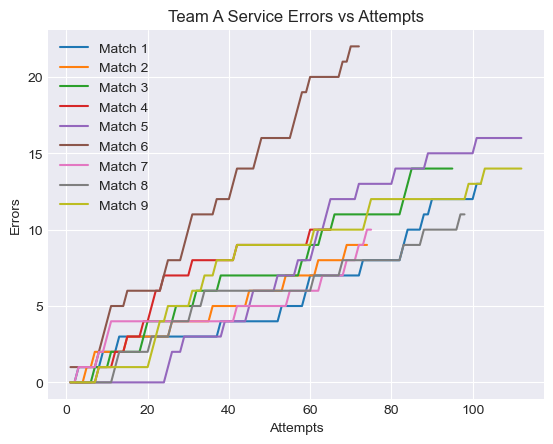

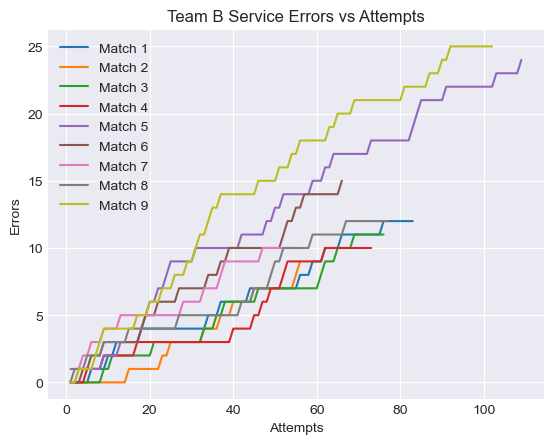

In [280]:

fig, ax = plt.subplots()
plt.style.use('seaborn-v0_8-darkgrid')
for match, group in serve_a.groupby('match'):
    group.plot(x='serve_attempts', y='running_serve_errors_match', ax=ax)
    plt.xlabel('Attempts')
    plt.ylabel('Errors')
    plt.title("Team A Service Errors vs Attempts") 
    plt.legend(['Match 1','Match 2','Match 3','Match 4','Match 5','Match 6','Match 7','Match 8','Match 9'])
fig, ax1 = plt.subplots()
plt.style.use('seaborn-v0_8-darkgrid')
for match, group in serve_b.groupby('match'):
    group.plot(x='serve_attempts', y='running_serve_errors_match', ax=ax1)
    plt.xlabel('Attempts')
    plt.ylabel('Errors')
    plt.title("Team B Service Errors vs Attempts") 
    plt.legend(['Match 1','Match 2','Match 3','Match 4','Match 5','Match 6','Match 7','Match 8','Match 9'])

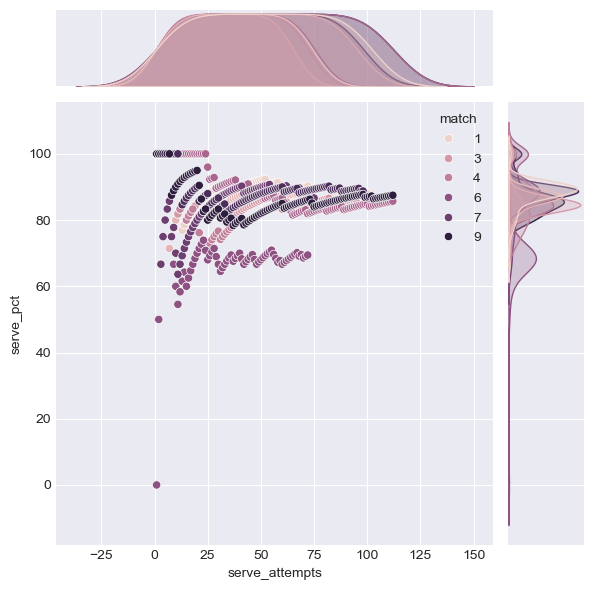

In [281]:
# joint plot for team a
sns.set_style('darkgrid')
a=sns.jointplot( x="serve_attempts",y="serve_pct",hue='match', data=serve_a )

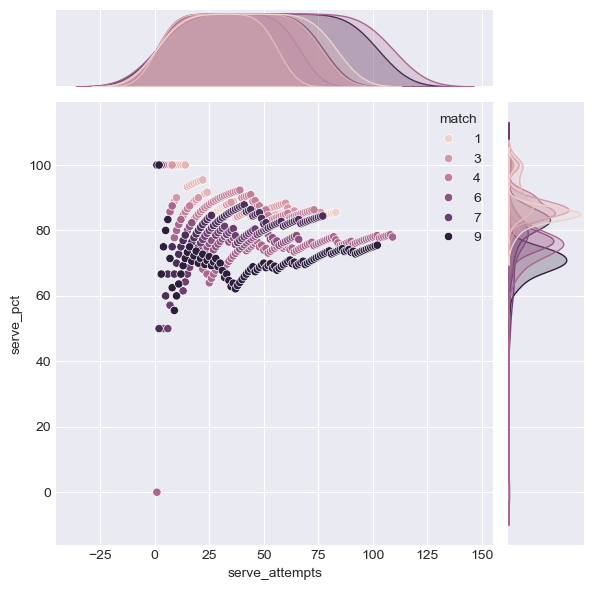

In [282]:
# joint plot for team b
sns.set_style('darkgrid')
sns.jointplot(x='serve_attempts',y='serve_pct',hue='match',data=serve_b)

Text(0.5, 1.0, 'Box Plot of Serve Efficiency Over Time(a)')

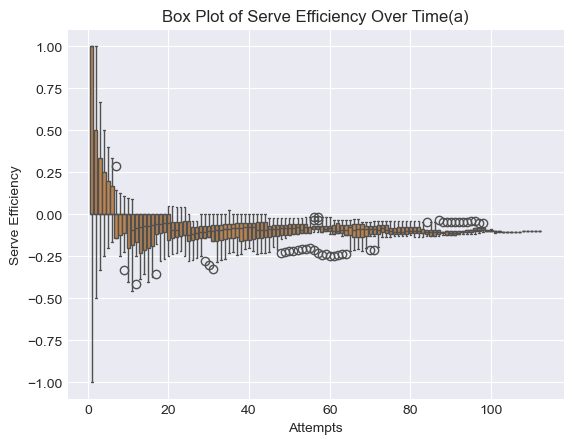

In [283]:
sns.set_style('darkgrid')
a=sns.boxplot(data=serve_a,x='serve_attempts',y='srv_eff',native_scale=True,color='peru')
a.set_xlabel('Attempts')
a.set_ylabel('Serve Efficiency')
a.set_title('Box Plot of Serve Efficiency Over Time(a)')

Text(0.5, 1.0, 'Box Plot of Serve Efficiency Over Time(b)')

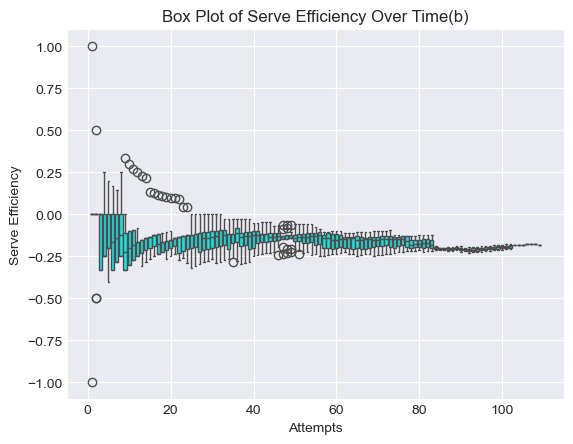

In [284]:
sns.set_style('darkgrid')
b=sns.boxplot(data=serve_b,x='serve_attempts',y='srv_eff',native_scale=True,color='aqua')
b.set_xlabel('Attempts')
b.set_ylabel('Serve Efficiency')
b.set_title('Box Plot of Serve Efficiency Over Time(b)')

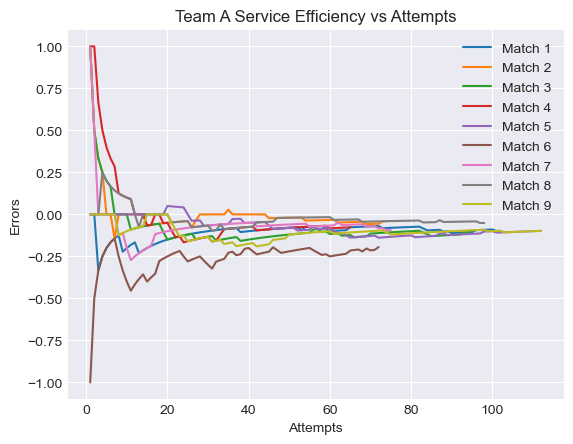

In [285]:
fig, ax = plt.subplots()
plt.style.use('seaborn-v0_8-darkgrid')
for match, group in serve_a.groupby('match'):
    group.plot(x='serve_attempts', y='srv_eff', ax=ax)
    plt.xlabel('Attempts')
    plt.ylabel('Errors')
    plt.title("Team A Service Efficiency vs Attempts") 
    plt.legend(['Match 1','Match 2','Match 3','Match 4','Match 5','Match 6','Match 7','Match 8','Match 9'])

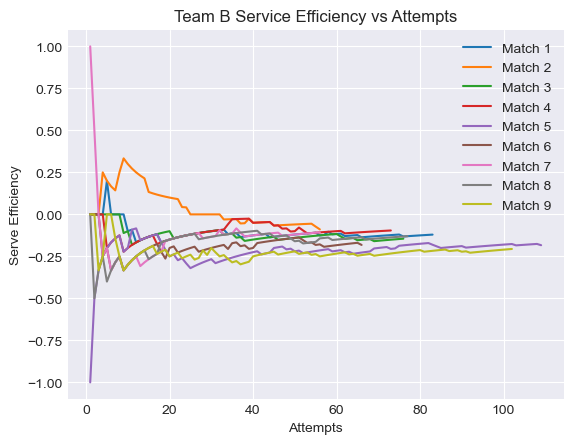

In [286]:
fig, ax = plt.subplots()
plt.style.use('seaborn-v0_8-darkgrid')
for match, group in serve_b.groupby('match'):
    group.plot(x='serve_attempts', y='srv_eff', ax=ax)
    plt.xlabel('Attempts')
    plt.ylabel('Serve Efficiency')
    plt.title("Team B Service Efficiency vs Attempts") 
    plt.legend(['Match 1','Match 2','Match 3','Match 4','Match 5','Match 6','Match 7','Match 8','Match 9'])

In [287]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [288]:
# create a data frame of serve percentage stationary ADF tests
# skims through by match to analyze each matches stationarity 
# .unique returns a unique pertaining to the specific group we are analyzing (returns 1-9 for the matches) 
results={}
for match_id in serve_a['match'].unique():
    per_match=serve_a[serve_a['match']==match_id]

    adf=adfuller(per_match['serve_pct'])
    results[match_id]={ 'match' : match_id , 'test_stat' : adf[0] , 'p_value' : adf[1], 'stationary' : adf[1]<.05} 

result_a_df=pd.DataFrame(results)  
result_a_df

,1,2,3,4,5,6,7,8,9
match,1,2,3,4,5,6,7,8,9
test_stat,-5.027127,-5.551821,-1.921946,-1.434383,-1.741689,-6.296304,-3.286841,-5.015217,-2.582012
p_value,0.00002,0.000002,0.321808,0.565686,0.409771,0.0,0.015477,0.000021,0.096772
stationary,True,True,False,False,False,True,True,True,False


In [289]:
# create a data frame of serve percentage stationary ADF tests
# skims through by match to analyze each matches stationarity 
# .unique returns a unique pertaining to the specific group we are analyzing (returns 1-9 for the matches) 
results={}
for match_id in serve_b['match'].unique():
    per_match=serve_b[serve_b['match']==match_id]

    adf=adfuller(per_match['serve_pct'])
    results[match_id]={ 'match' : match_id , 'test_stat' : adf[0] , 'p_value' : adf[1], 'stationary' : adf[1]<.05} 

result_b_df=pd.DataFrame(results)
result_b_df

,1,2,3,4,5,6,7,8,9
match,1,2,3,4,5,6,7,8,9
test_stat,-4.105353,-1.006953,-2.849096,-2.648836,-4.870177,-1.766944,-3.797192,-1.625218,-1.15304
p_value,0.000949,0.75072,0.051596,0.083318,0.00004,0.396992,0.002936,0.469995,0.693464
stationary,True,False,False,False,True,False,True,False,False


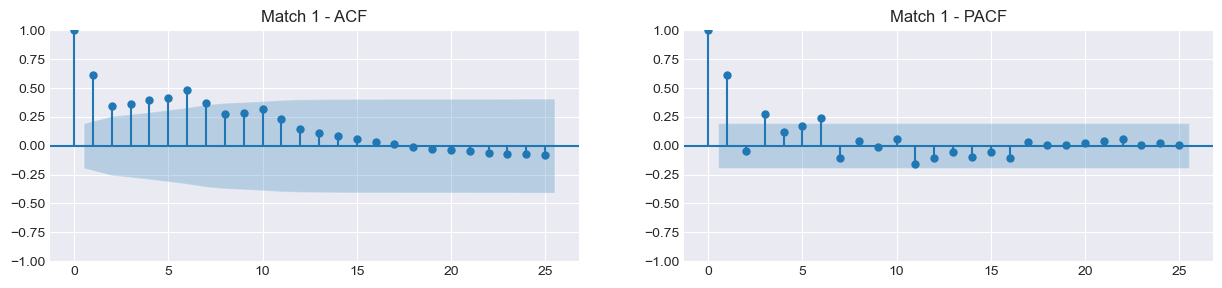

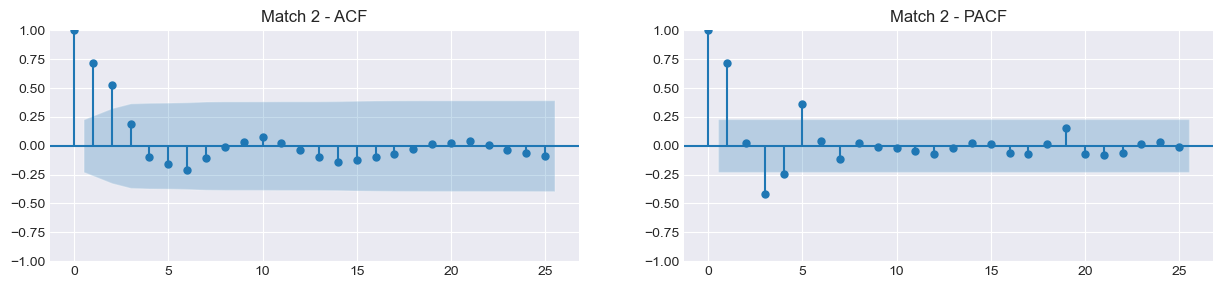

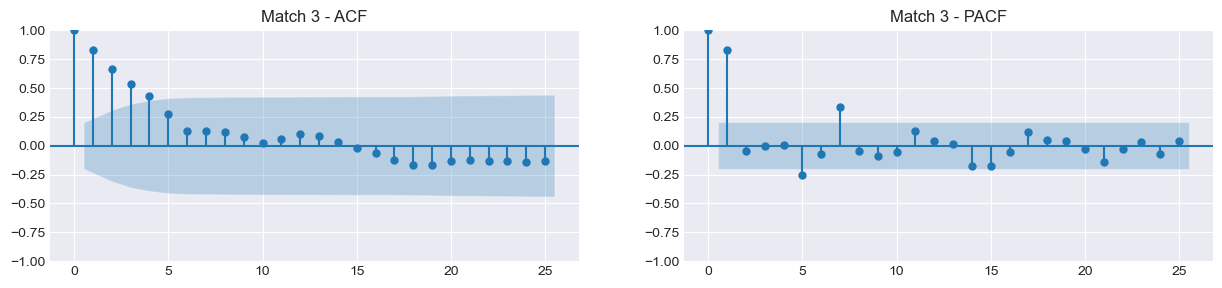

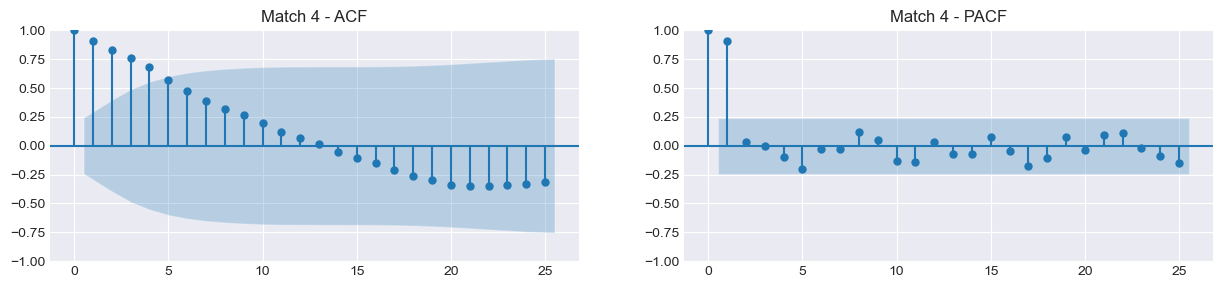

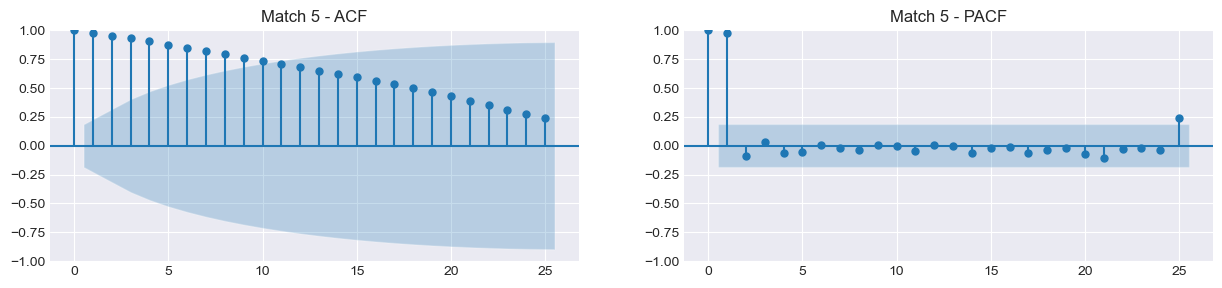

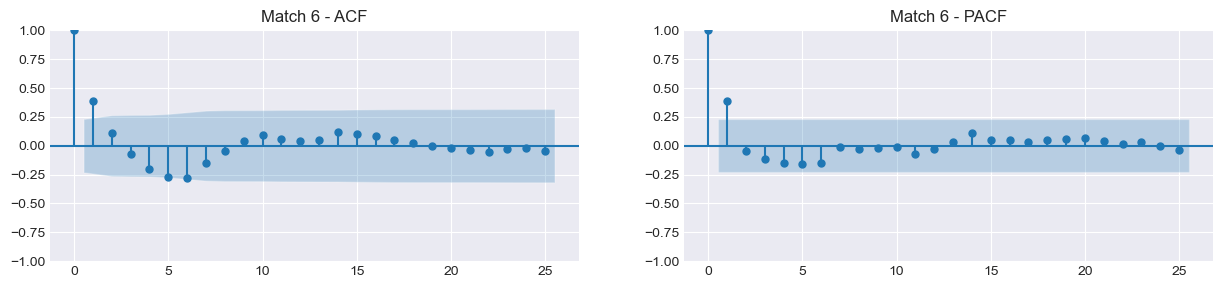

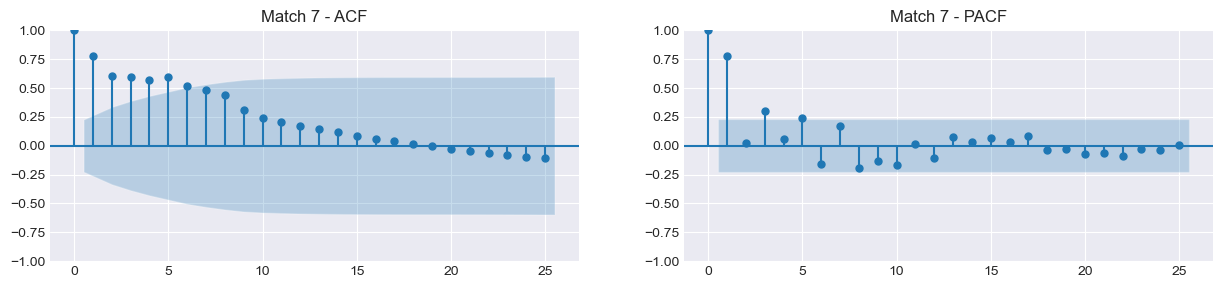

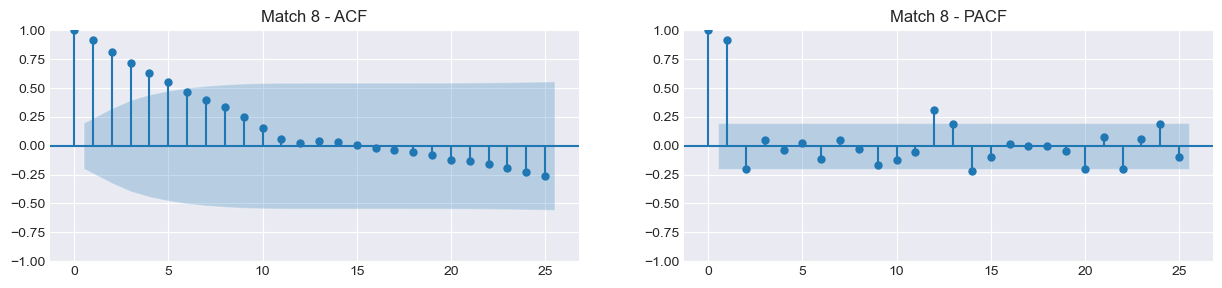

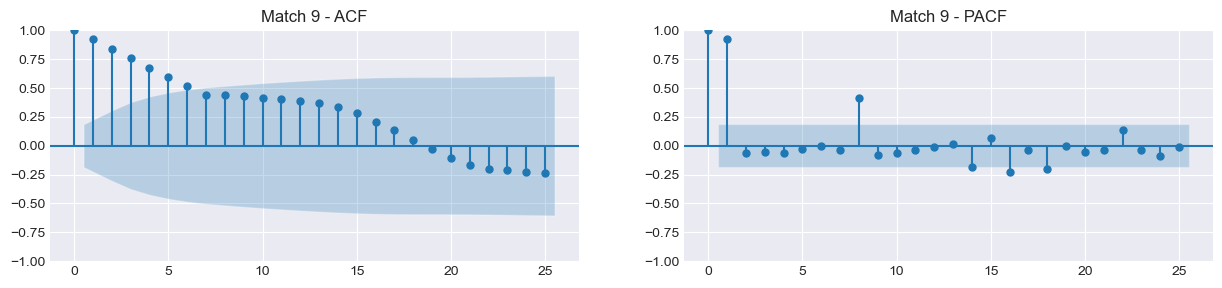

In [290]:
# all for team a
# way to show our acf and pacf's quickly and efficiently 
# uses a for loop to quickly run through each unique match and it's specific serve data
for match_id in serve_a['match'].unique():
    # creates a dataframe with our serving data by match
    per_match=serve_a[serve_a['match']==match_id]
    # creates a 1 by 2 subplot for each separate match and plots the acf in axis[0] and the pacf in axis[1] of our subplot
    # this repeated for each match so although it looks like a 9x2 subplot its really 9 1 by 2 subplots 
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    plot_acf(per_match['serve_pct'], lags=25, ax=axes[0])
    plot_pacf(per_match['serve_pct'], lags=25, ax=axes[1])
    # specifies 
    axes[0].set_title(f'Match {match_id} - ACF')
    axes[1].set_title(f'Match {match_id} - PACF')
    plt.show()

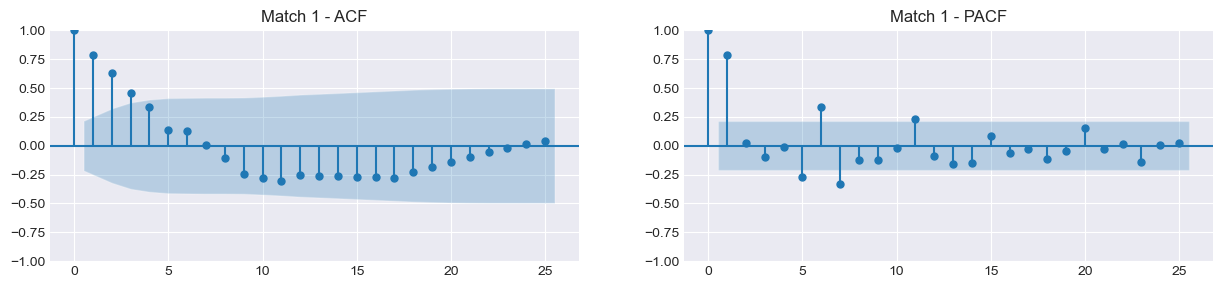

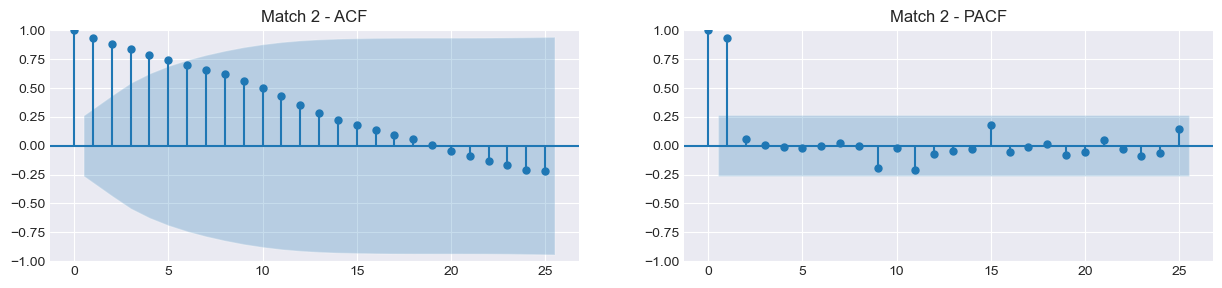

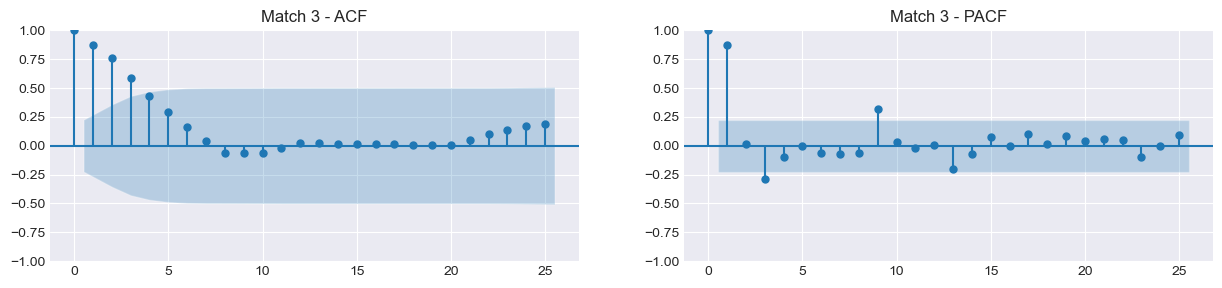

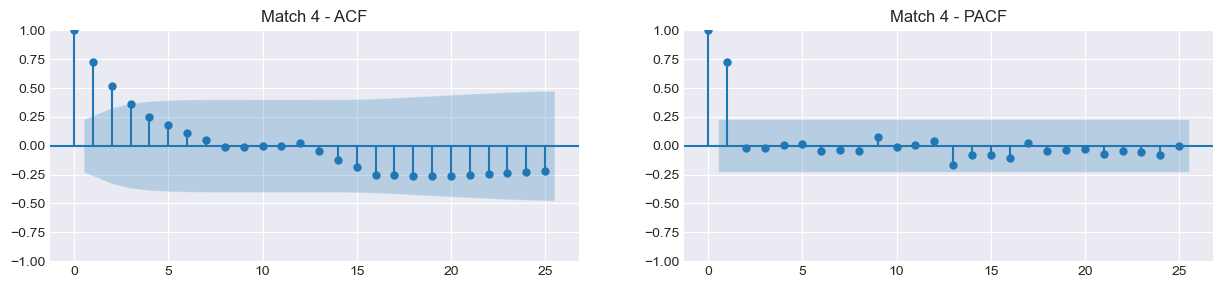

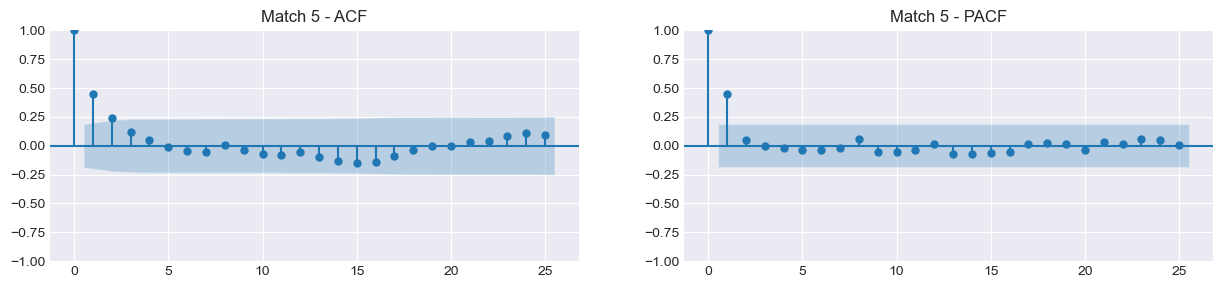

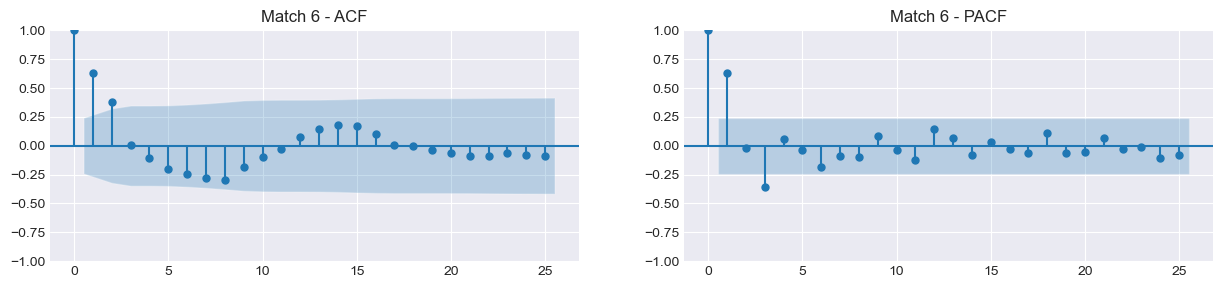

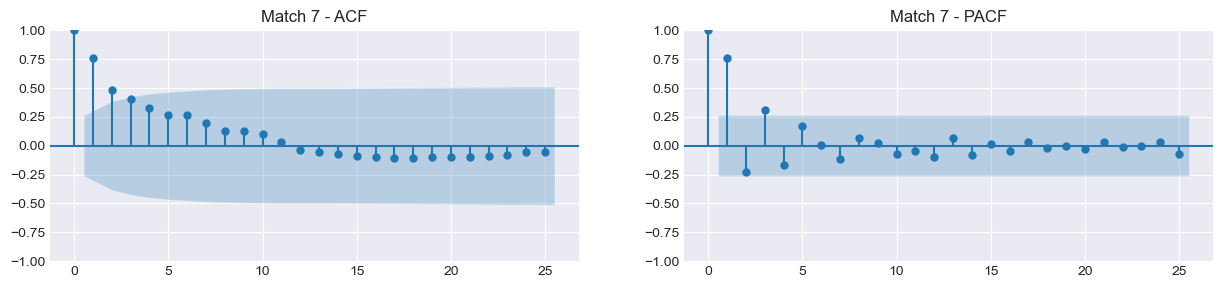

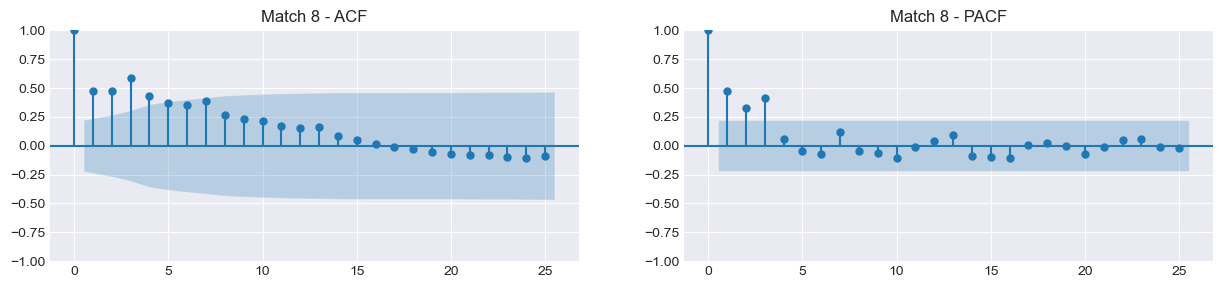

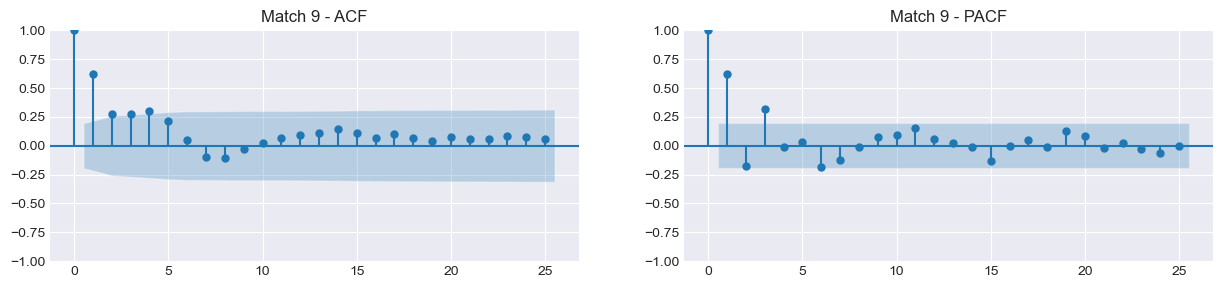

In [291]:
# all for team b
# way to show our acf and pacf's quickly and efficiently 
# uses a for loop to quickly run through each unique match and it's specific serve data
for match_id in serve_b['match'].unique():
     # creates a dataframe with our serving data by match
    per_match=serve_b[serve_b['match']==match_id]
    # creates a 1 by 2 subplot for each separate match and plots the acf in axis[0] and the pacf in axis[1] of our subplot
    # this repeated for each match so although it looks like a 9x2 subplot its really 9 1 by 2 subplots 
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    plot_acf(per_match['serve_pct'], lags=25, ax=axes[0])
    plot_pacf(per_match['serve_pct'], lags=25, ax=axes[1])
    axes[0].set_title(f'Match {match_id} - ACF')
    axes[1].set_title(f'Match {match_id} - PACF')
    plt.show()

In [292]:
from pmdarima import auto_arima
# use auto arima on the highest 3 serve totals for each team which are the following 
# for team_a that would be match 1,5,9
# for team_b that would be match 1,5,9 

In [293]:

m1a=serve_a[serve_a['match']==1]
test=auto_arima(m1a['serve_pct'],max_d=2)

In [294]:
test.order

(2, 1, 2)

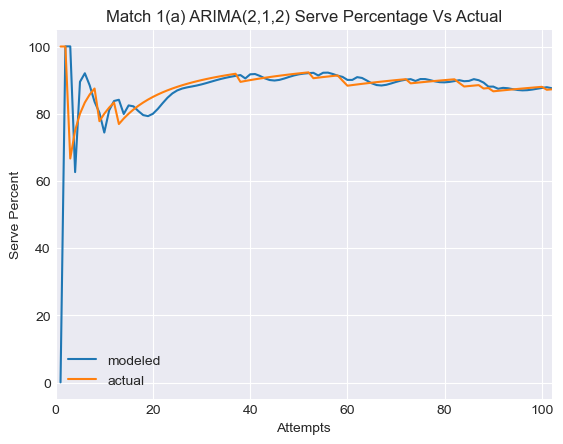

In [295]:

x = np.arange(1, 103)  # 1–102 inclusive

plt.plot(x, test.fittedvalues())
plt.plot(x, m1a['serve_pct'].values)
plt.xlim(0,102)
plt.xlabel('Attempts')
plt.ylabel('Serve Percent')
plt.title('Match 1(a) ARIMA(2,1,2) Serve Percentage Vs Actual' )
plt.legend(['modeled','actual'])
plt.show()

In [296]:
m5a=serve_a[serve_a['match']==5]
test5a=auto_arima(m5a['serve_pct'],max_d=2)

In [297]:
test5a.order

(0, 1, 2)

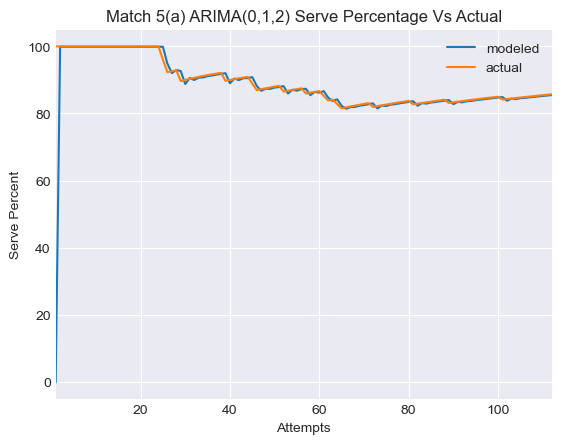

In [298]:
x = np.arange(1, 113)  # 1–112 inclusive

plt.plot(x, test5a.fittedvalues())
plt.plot(x, m5a['serve_pct'].values)
plt.xlim(1,112)
plt.xlabel('Attempts')
plt.ylabel('Serve Percent')
plt.title('Match 5(a) ARIMA(0,1,2) Serve Percentage Vs Actual' )
plt.legend(['modeled','actual'])
plt.show()

In [299]:
m9a=serve_a[serve_a['match']==9]
test9a=auto_arima(m9a['serve_pct'],max_d=1)

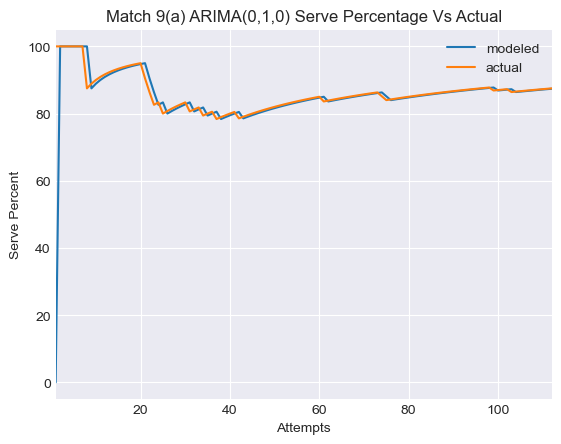

In [300]:
x = np.arange(1, 113)  # 1–112 inclusive

plt.plot(x, test9a.fittedvalues())
plt.plot(x, m9a['serve_pct'].values)
plt.xlim(1,112)
plt.xlabel('Attempts')
plt.ylabel('Serve Percent')
plt.title('Match 9(a) ARIMA(0,1,0) Serve Percentage Vs Actual' )
plt.legend(['modeled','actual'])
plt.show()

In [301]:
m1b=serve_b[serve_b['match']==1]
test1b=auto_arima(m1b['serve_pct'],max_d=2)

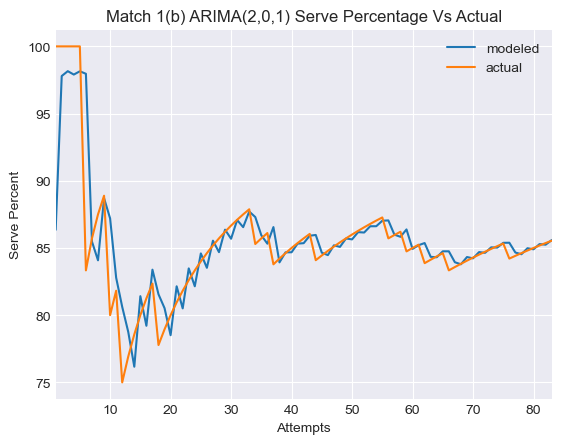

In [302]:
x = np.arange(1, 84)  # 1–83 inclusive

plt.plot(x, test1b.fittedvalues())
plt.plot(x, m1b['serve_pct'].values)
plt.xlim(1,83)
plt.xlabel('Attempts')
plt.ylabel('Serve Percent')
plt.title('Match 1(b) ARIMA(2,0,1) Serve Percentage Vs Actual' )
plt.legend(['modeled','actual'])
plt.show()

In [303]:
m5b=serve_b[serve_b['match']==5]
test5b=auto_arima(m5b['serve_pct'],max_d=2)

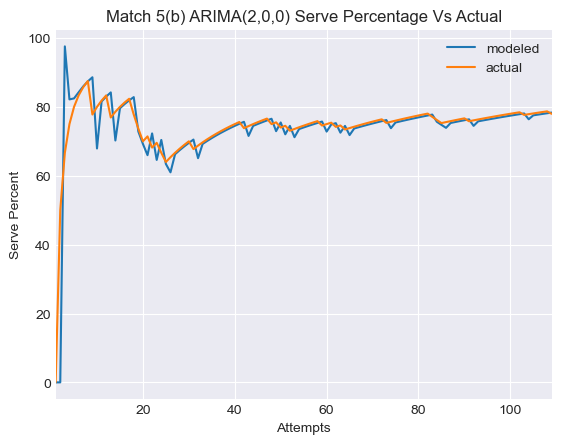

In [304]:
x = np.arange(1, 110)  # 1–112 inclusive

plt.plot(x, test5b.fittedvalues())
plt.plot(x, m5b['serve_pct'].values)
plt.xlim(1,109)
plt.xlabel('Attempts')
plt.ylabel('Serve Percent')
plt.title('Match 5(b) ARIMA(2,0,0) Serve Percentage Vs Actual' )
plt.legend(['modeled','actual'])
plt.show()

In [305]:
m9b=serve_b[serve_b['match']==9]
test9b=auto_arima(m9b['serve_pct'],max_d=2)

In [306]:
test9b.order

(4, 0, 2)

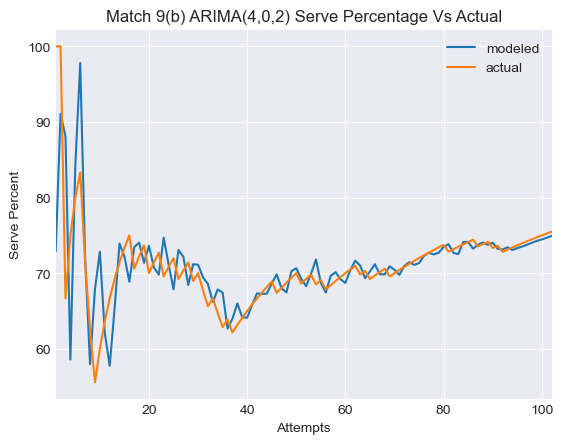

In [307]:
x = np.arange(1, 103)  # 1–102 inclusive

plt.plot(x, test9b.fittedvalues())
plt.plot(x, m9b['serve_pct'].values)
plt.xlim(1,102)
plt.xlabel('Attempts')
plt.ylabel('Serve Percent')
plt.title('Match 9(b) ARIMA(4,0,2) Serve Percentage Vs Actual' )
plt.legend(['modeled','actual'])
plt.show()

In [308]:
residuals={'1a':(test.resid()).mean(),'5a':(test5a.resid()).mean(),'9a':(test9a.resid()).mean(),
           '1b':(test1b.resid()).mean(),'5b':(test5b.resid()).mean(),'9b':(test9b.resid()).mean()}
diagnostics=pd.Series(residuals)
diagnostics

1a    0.692421
5a    0.894072
9a    0.781250
1b   -0.167288
5b    0.539603
9b   -0.148364
dtype: float64

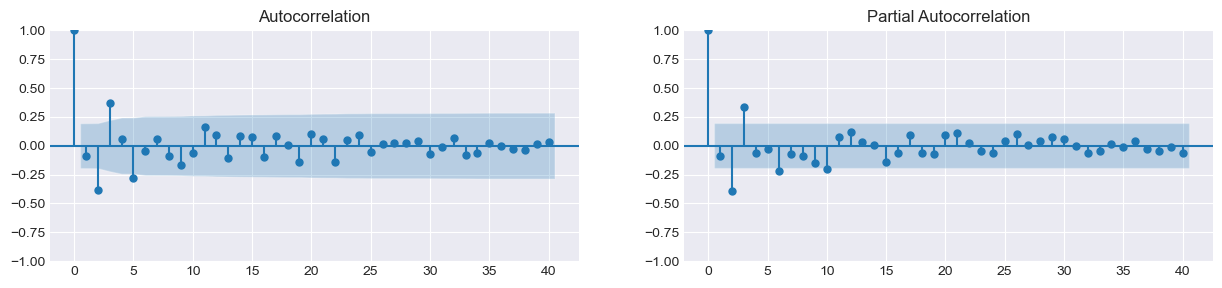

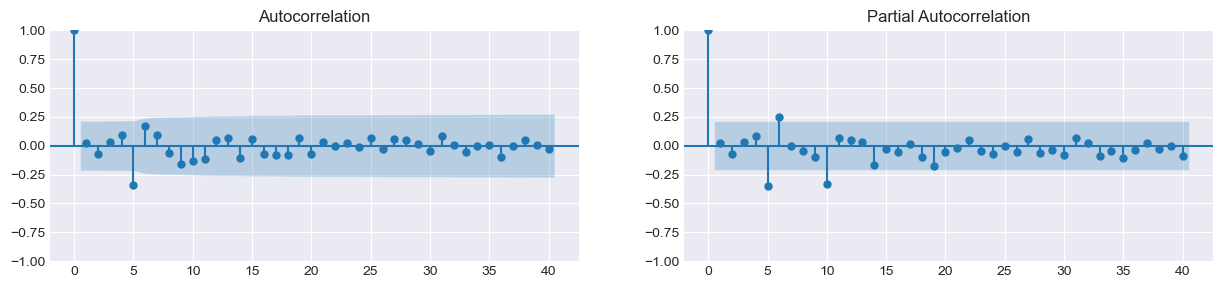

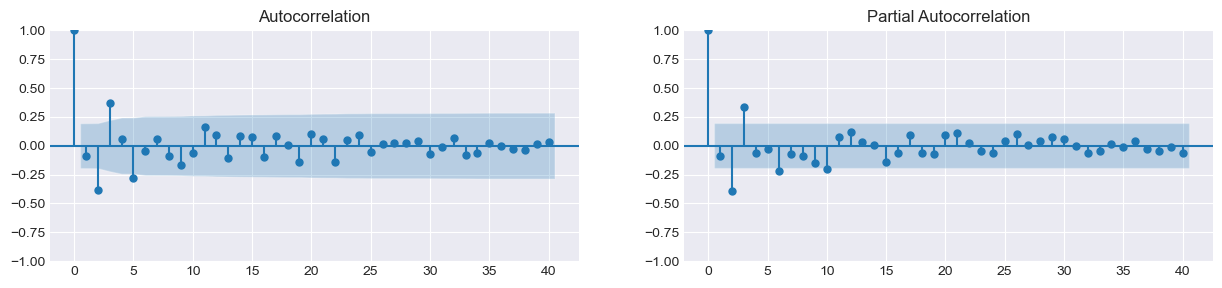

In [309]:
# looking further into our two best models 9b and 1b 
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
plot_acf(test1b.resid(),lags=40,ax=axes[0])
plot_pacf(test1b.resid(),lags=40,ax=axes[1])
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
plot_acf(test9b.resid(),lags=40,ax=axes[0])
plot_pacf(test9b.resid(),lags=40,ax=axes[1])
# from our acf and our pacf's we see that our residuals are indepedenent 

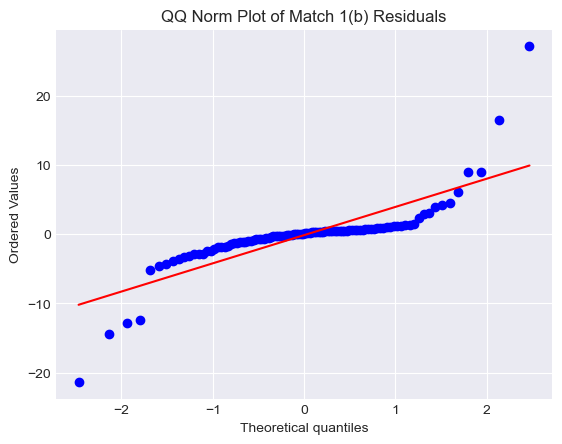

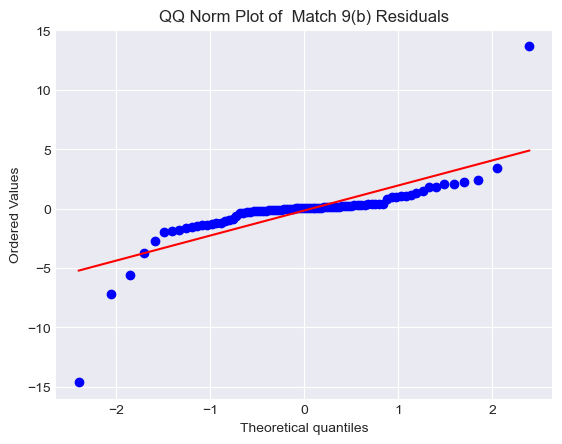

In [310]:
import scipy.stats as stats
res9=test9b.resid()
res1=test1b.resid()
stats.probplot(res9, dist="norm", plot=plt)
plt.title("QQ Norm Plot of Match 1(b) Residuals")
plt.show()
stats.probplot(res1, dist="norm", plot=plt)
plt.title("QQ Norm Plot of  Match 9(b) Residuals")
plt.show()
# pretty quickly determine our residuals are not normally distributed 

Text(0, 0.5, 'Count')

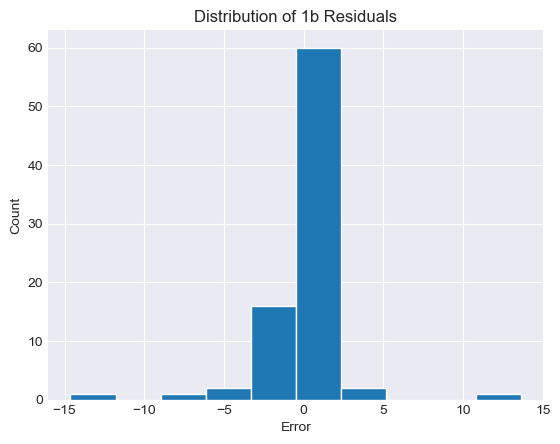

In [311]:
plt.hist(res1)
plt.title('Distribution of 1b Residuals')
plt.xlabel('Error')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

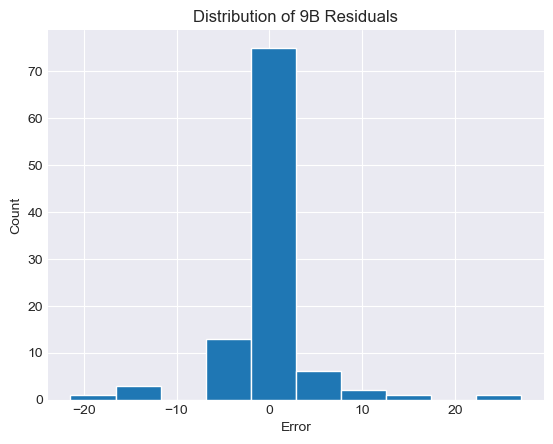

In [312]:
plt.hist(res9)
plt.title('Distribution of 9B Residuals')
plt.xlabel('Error')
plt.ylabel('Count')

C:\Users\ian_b\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ian_b\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Text(0, 0.5, 'Serve Percentage')

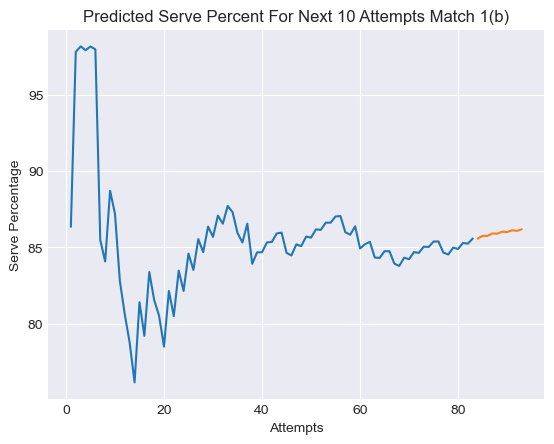

In [313]:
pred1b=test1b.predict(n_periods=10)
x_prior=np.arange(1,len(test1b.fittedvalues())+1)
x_pred=np.arange(len(test1b.fittedvalues())+1,len(test1b.fittedvalues())+1+len(pred1b))
plt.plot(x_prior,test1b.fittedvalues())
plt.plot(x_pred,pred1b)
plt.title('Predicted Serve Percent For Next 10 Attempts Match 1(b)')
plt.xlabel('Attempts')
plt.ylabel('Serve Percentage')

C:\Users\ian_b\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ian_b\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Text(0, 0.5, 'Serve Percentage')

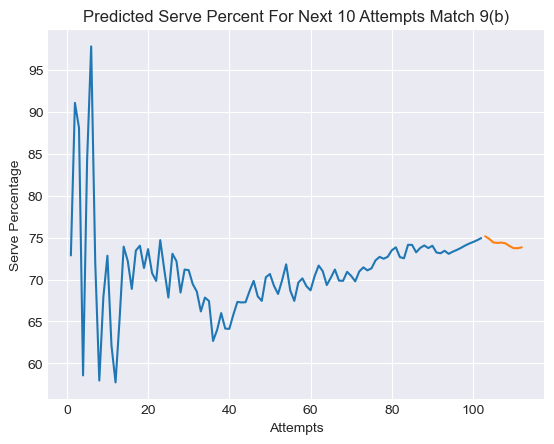

In [314]:
pred9b=test9b.predict(n_periods=10)
x_prior=np.arange(1,len(test9b.fittedvalues())+1)
x_pred=np.arange(len(test9b.fittedvalues())+1,len(test9b.fittedvalues())+1+len(pred9b))
plt.plot(x_prior,test9b.fittedvalues())
plt.plot(x_pred,pred9b)
plt.title('Predicted Serve Percent For Next 10 Attempts Match 9(b)')
plt.xlabel('Attempts')
plt.ylabel('Serve Percentage')

In [354]:
# preparing our float only dataset 
float_data=serve_data[serve_data['serve_type']=='float']
float_data.dropna()
# serve attempts 
float_data['serve_attempts']=float_data.groupby('match').cumcount()+1
# service errors 
float_data['serve_errors']=0
float_data['serve_errors']=float_data['serve_errors'].mask(float_data['lose_reason']=='serve_error',1)
float_data['running_serve_errors_match']=float_data.groupby('match')['serve_errors'].cumsum()
float_data.drop('serve_errors',axis=1,inplace=True)
# getting running aces and aces totals 
float_data['aces']=0
float_data['aces']=float_data['aces'].mask(float_data['win_reason']=='ace',1)
float_data['running_aces_in_match']=float_data.groupby('match')['aces'].cumsum()
float_data.drop('aces',axis=1,inplace=True)
# serve pct by match 
float_data['serve_pct']=float_data.groupby('match').apply(lambda df : (((df['serve_attempts']-df['running_serve_errors_match'])/df['serve_attempts']))).reset_index(0,drop=True) 
# average serve rating by match 
float_data['running_rating']=float_data.groupby('match')['srv_rating'].expanding().mean().reset_index(0,drop=True)
# running serve efficiency 
float_data['srv_eff']=float_data.groupby('match').apply(lambda df : ((df['running_aces_in_match']-df['running_serve_errors_match'])/df['serve_attempts'])).reset_index(0,drop=True)
float_data

C:\Users\ian_b\AppData\Local\Temp\ipykernel_5212\1589395003.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  float_data['serve_attempts']=float_data.groupby('match').cumcount()+1
C:\Users\ian_b\AppData\Local\Temp\ipykernel_5212\1589395003.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  float_data['serve_errors']=0
C:\Users\ian_b\AppData\Local\Temp\ipykernel_5212\1589395003.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,match,rally,round,team,receive_location,digger_location,pass_land_location,hitter_location,hit_land_location,pass_rate(0-3),...,win_reason,lose_reason,winning_team,srv_rating,serve_attempts,running_serve_errors_match,running_aces_in_match,serve_pct,running_rating,srv_eff
12,1,5,1.0,a,7.0,8.0,13.0,14.0,6.0,3,...,kill,kill,a,1,1,0,0,1.000000,1.000000,0.000000
16,1,9,1.0,b,8.0,8.0,8.0,15.0,21.0,2,...,hit_error,hit_error,a,2,2,0,0,1.000000,1.500000,0.000000
17,1,10,1.0,b,9.0,8.0,13.0,14.0,10.0,3,...,kill,kill,b,1,3,0,0,1.000000,1.333333,0.000000
25,1,15,1.0,a,8.0,8.0,13.0,11.0,8.0,3,...,ongoing,ongoing,b,1,4,0,0,1.000000,1.250000,0.000000
27,1,16,1.0,a,8.0,8.0,13.0,14.0,12.0,3,...,kill,kill,a,1,5,0,0,1.000000,1.200000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,9,204,1.0,b,7.0,7.0,12.0,15.0,10.0,2,...,ongoing,ongoing,a,2,52,3,1,0.942308,1.596154,-0.038462
2414,9,205,1.0,b,8.0,8.0,13.0,11.0,3.0,3,...,ongoing,ongoing,a,1,53,3,1,0.943396,1.584906,-0.037736
2417,9,206,1.0,b,8.0,8.0,13.0,15.0,9.0,3,...,ongoing,ongoing,a,1,54,3,1,0.944444,1.574074,-0.037037
2420,9,207,1.0,b,8.0,8.0,12.0,15.0,4.0,2,...,kill,kill,b,2,55,3,1,0.945455,1.581818,-0.036364


In [355]:
# preparing our float only dataset for team a 
jump_data=serve_data[serve_data['serve_type']=='jump']
jump_data.dropna()
# serve attempts 
jump_data['serve_attempts']=jump_data.groupby('match').cumcount()+1
# service errors 
jump_data['serve_errors']=0
jump_data['serve_errors']=jump_data['serve_errors'].mask(jump_data['lose_reason']=='serve_error',1)
jump_data['running_serve_errors_match']=jump_data.groupby('match')['serve_errors'].cumsum()
jump_data.drop('serve_errors',axis=1,inplace=True)
# getting running aces and aces totals 
jump_data['aces']=0
jump_data['aces']=jump_data['aces'].mask(jump_data['win_reason']=='ace',1)
jump_data['running_aces_in_match']=jump_data.groupby('match')['aces'].cumsum()
jump_data.drop('aces',axis=1,inplace=True)
# serve pct by match 
jump_data['serve_pct']=jump_data.groupby('match').apply(lambda df : (((df['serve_attempts']-df['running_serve_errors_match'])/df['serve_attempts']))).reset_index(0,drop=True) 
# average serve rating by match 
jump_data['running_rating_b']=jump_data.groupby('match')['srv_rating'].expanding().mean().reset_index(0,drop=True)
# running serve efficiency 
jump_data['srv_eff']=jump_data.groupby('match').apply(lambda df : ((df['running_aces_in_match']-df['running_serve_errors_match'])/df['serve_attempts'])).reset_index(0,drop=True)
jump_data

C:\Users\ian_b\AppData\Local\Temp\ipykernel_5212\1979235927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jump_data['serve_attempts']=jump_data.groupby('match').cumcount()+1
C:\Users\ian_b\AppData\Local\Temp\ipykernel_5212\1979235927.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jump_data['serve_errors']=0
C:\Users\ian_b\AppData\Local\Temp\ipykernel_5212\1979235927.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,match,rally,round,team,receive_location,digger_location,pass_land_location,hitter_location,hit_land_location,pass_rate(0-3),...,win_reason,lose_reason,winning_team,srv_rating,serve_attempts,running_serve_errors_match,running_aces_in_match,serve_pct,running_rating_b,srv_eff
0,1,1,1.0,b,4.0,4.0,13.0,13.0,7.0,3,...,ongoing,ongoing,a,1,1,0,0,1.000000,1.000000,0.000000
8,1,2,1.0,b,3.0,3.0,13.0,14.0,2.0,3,...,kill,kill,b,1,2,0,0,1.000000,1.000000,0.000000
9,1,3,1.0,a,2.0,2.0,12.0,11.0,11.0,2,...,ongoing,ongoing,a,2,3,0,0,1.000000,1.333333,0.000000
11,1,4,1.0,b,-1.0,-1.0,-1.0,-1.0,-1.0,-1,...,serve_error,serve_error,b,0,4,1,0,0.750000,1.000000,-0.250000
13,1,6,1.0,b,4.0,3.0,26.0,15.0,20.0,1,...,hit_error,hit_error,a,3,5,1,0,0.800000,1.400000,-0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2422,9,209,1.0,b,3.0,3.0,26.0,6.0,1.0,1,...,kill,kill,b,3,145,36,5,0.751724,1.282759,-0.213793
2423,9,210,1.0,a,3.0,3.0,8.0,15.0,18.0,2,...,tool,tool,a,2,146,36,5,0.753425,1.287671,-0.212329
2424,9,211,1.0,b,7.0,2.0,8.0,15.0,3.0,2,...,ongoing,ongoing,a,2,147,36,5,0.755102,1.292517,-0.210884
2426,9,212,1.0,b,7.0,7.0,13.0,15.0,17.0,3,...,hit_error,hit_error,a,1,148,36,5,0.756757,1.290541,-0.209459


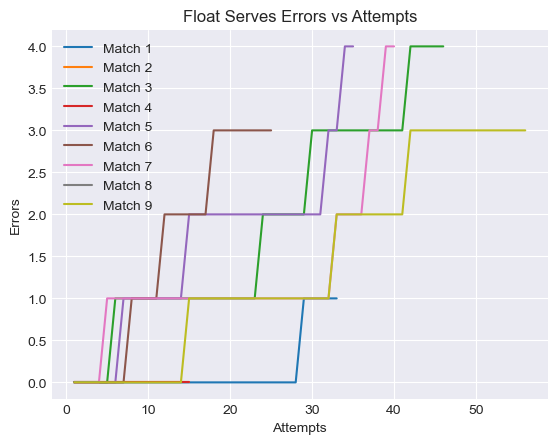

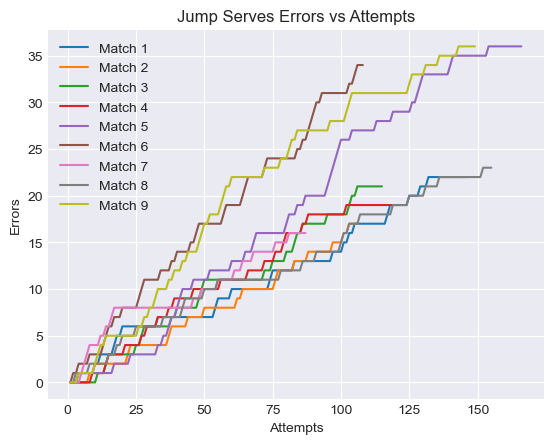

In [357]:
fig, ax= plt.subplots()
for match, group in float_data.groupby('match'):
    group.plot(x='serve_attempts', y='running_serve_errors_match', ax=ax)
    plt.xlabel('Attempts')
    plt.ylabel('Errors')
    plt.title("Float Serves Errors vs Attempts") 
    plt.legend(['Match 1','Match 2','Match 3','Match 4','Match 5','Match 6','Match 7','Match 8','Match 9'])  
fig, ax1= plt.subplots()    
for match, group in jump_data.groupby('match'):
    group.plot(x='serve_attempts', y='running_serve_errors_match', ax=ax1)
    plt.xlabel('Attempts')
    plt.ylabel('Errors')
    plt.title("Jump Serves Errors vs Attempts") 
    plt.legend(['Match 1','Match 2','Match 3','Match 4','Match 5','Match 6','Match 7','Match 8','Match 9']) 

Text(0.5, 1.0, 'Box Plot of Jump Serve Efficiency Over Time(a)')

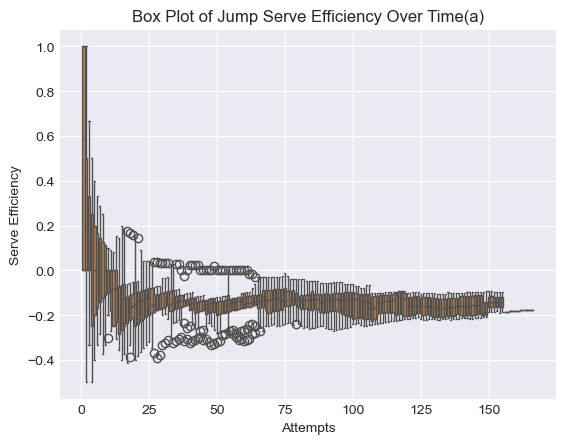

In [358]:
sns.set_style('darkgrid')
a=sns.boxplot(data=jump_data,x='serve_attempts',y='srv_eff',native_scale=True,color='peru')
a.set_xlabel('Attempts')
a.set_ylabel('Serve Efficiency')
a.set_title('Box Plot of Jump Serve Efficiency Over Time(a)')

Text(0.5, 1.0, 'Box Plot of Float Serve Efficiency Over Time(a)')

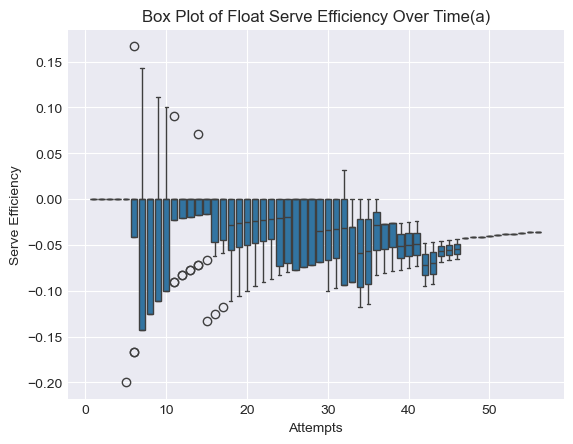

In [359]:
sns.set_style('darkgrid')
a=sns.boxplot(data=float_data,x='serve_attempts',y='srv_eff',native_scale=True)
a.set_xlabel('Attempts')
a.set_ylabel('Serve Efficiency')
a.set_title('Box Plot of Float Serve Efficiency Over Time(a)')

Text(0.5, 1.0, 'Histogram and KDE of Float Serve Efficiency')

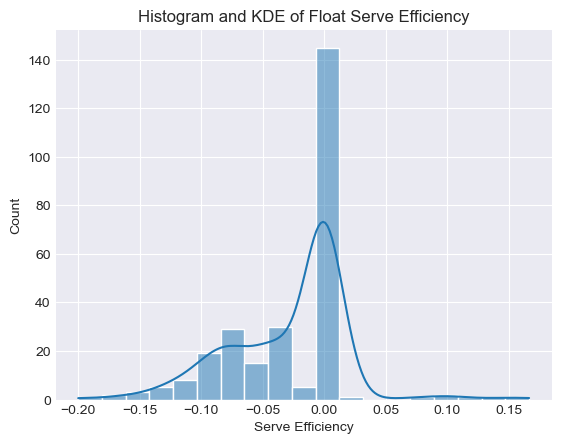

In [362]:
f=sns.histplot(data=float_data,x='srv_eff',kde=True)
f.set_xlabel('Serve Efficiency')
f.set_title('Histogram and KDE of Float Serve Efficiency')

Text(0.5, 1.0, 'Histogram and KDE of Jump Serve Efficiency')

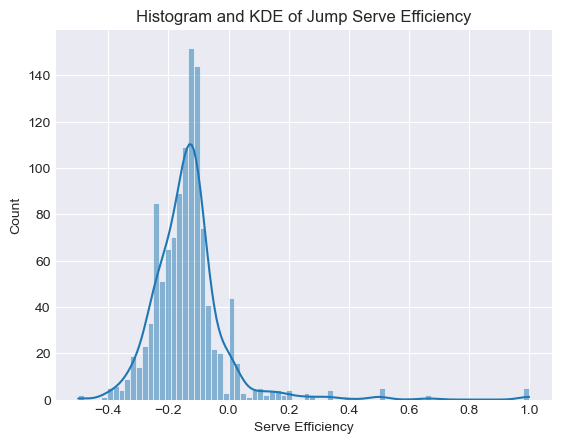

In [363]:
j=sns.histplot(data=jump_data,x='srv_eff',kde=True)
j.set_xlabel('Serve Efficiency')
j.set_title('Histogram and KDE of Jump Serve Efficiency')